In [7]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mesa import Model, Agent
from mesa.space import SingleGrid
from mesa.time import RandomActivation
import numpy as np

# Requerimientos

1. El rancho es un espacio de 20 x 20 celdas.
2. Inicialmente, en el rancho hay 150 ovejas. Solo hay una oveja por espacio. Cada oveja empieza en un espacio aleatorio.
3. Todos los agentes empiezan en posición aleatorias vacías.
4. La simulación debe parar cuando logres una eficiencia de pastoreo (se explica más adelante) mayor al 90%.
5. Implementa dos soluciones: una solución sin ninguna estrategia de coordinación (basado en movimientos al azar) y una solución que emplee una estrategia que permita reducir el número de iteraciones.
6. Debe ser posible visualizar de una simulación

## Eficiencia

Eficiencia = (espacions sin ovejas alrededor) / (# de espacios) - (# de ovejas)

In [8]:
class Pastor(Agent):
    def __init__(self, unique_id, model, strategy="random"):
        super().__init__(unique_id, model)
        self.carrying_sheep = False
        self.strategy = strategy
    
    def step(self):
        if self.strategy == "random":
            self.random_move()
        else:
            self.coordinated_move()
        self.interact_with_sheep()

    def random_move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        empty_steps = [pos for pos in possible_steps if self.model.grid.is_cell_empty(pos)]
        if empty_steps:
            new_position = self.random.choice(empty_steps)
            self.model.grid.move_agent(self, new_position)

    def coordinated_move(self):
        sheep_density_map = self.model.sheep_layer
        best_cell = max(self.model.grid.get_neighborhood(self.pos, moore=True, radius=3),
                        key=lambda pos: sheep_density_map[pos[0]][pos[1]])
        
        if best_cell != self.pos and self.model.grid.is_cell_empty(best_cell):
            self.model.grid.move_agent(self, best_cell)
        else:
            self.random_move()

    def interact_with_sheep(self):
        x, y = self.pos
        if not self.carrying_sheep and self.model.sheep_layer[x][y] > 0:
            self.pick_up_sheep()
        elif self.carrying_sheep:
            self.drop_sheep()

    def pick_up_sheep(self):
        x, y = self.pos
        self.model.sheep_layer[x][y] -= 1
        self.carrying_sheep = True

    def drop_sheep(self):
        nearby_positions = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        empty_positions = [pos for pos in nearby_positions if self.model.sheep_layer[pos[0]][pos[1]] == 0]
        if empty_positions:
            drop_pos = self.random.choice(empty_positions)
            self.model.sheep_layer[drop_pos[0]][drop_pos[1]] += 1
            self.carrying_sheep = False


In [9]:
class Rancho(Model):
    def __init__(self, width=20, height=20, initial_sheep=150, num_pastores=5, strategy="random"):
        self.grid = SingleGrid(width, height, True)
        self.num_pastores = num_pastores
        self.initial_sheep = initial_sheep
        self.schedule = RandomActivation(self)
        self.strategy = strategy
        
        self.sheep_layer = np.zeros((width, height), dtype=int)
        
        sheep_positions = self.random.sample([(x, y) for x in range(width) for y in range(height)], initial_sheep)
        for x, y in sheep_positions:
            self.sheep_layer[x][y] = 1
        
        for i in range(self.num_pastores):
            x, y = self.random_position()
            pastor = Pastor(i, self, strategy)
            self.grid.place_agent(pastor, (x, y))
            self.schedule.add(pastor)
        
        self.efficiency_history = []

    def random_position(self):
        while True:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            if self.grid.is_cell_empty((x, y)) and self.sheep_layer[x][y] == 0:
                return x, y

    def calculate_efficiency(self):
        total_spaces = self.grid.width * self.grid.height
        sheep_count = np.sum(self.sheep_layer)
        empty_spaces = np.sum([
            (self.sheep_layer[x, y] == 0) and
            all(self.sheep_layer[nx, ny] == 0 for nx, ny in self.grid.get_neighborhood((x, y), moore=True, include_center=False))
            for x in range(self.grid.width) for y in range(self.grid.height)
        ])
        efficiency = empty_spaces / (total_spaces - sheep_count) if total_spaces > sheep_count else 0
        return efficiency

    def step(self):
        self.schedule.step()
        efficiency = self.calculate_efficiency()
        self.efficiency_history.append(efficiency)
        return efficiency > 0.9


C:\Users\die_g\AppData\Local\Temp\ipykernel_31244\104570145.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


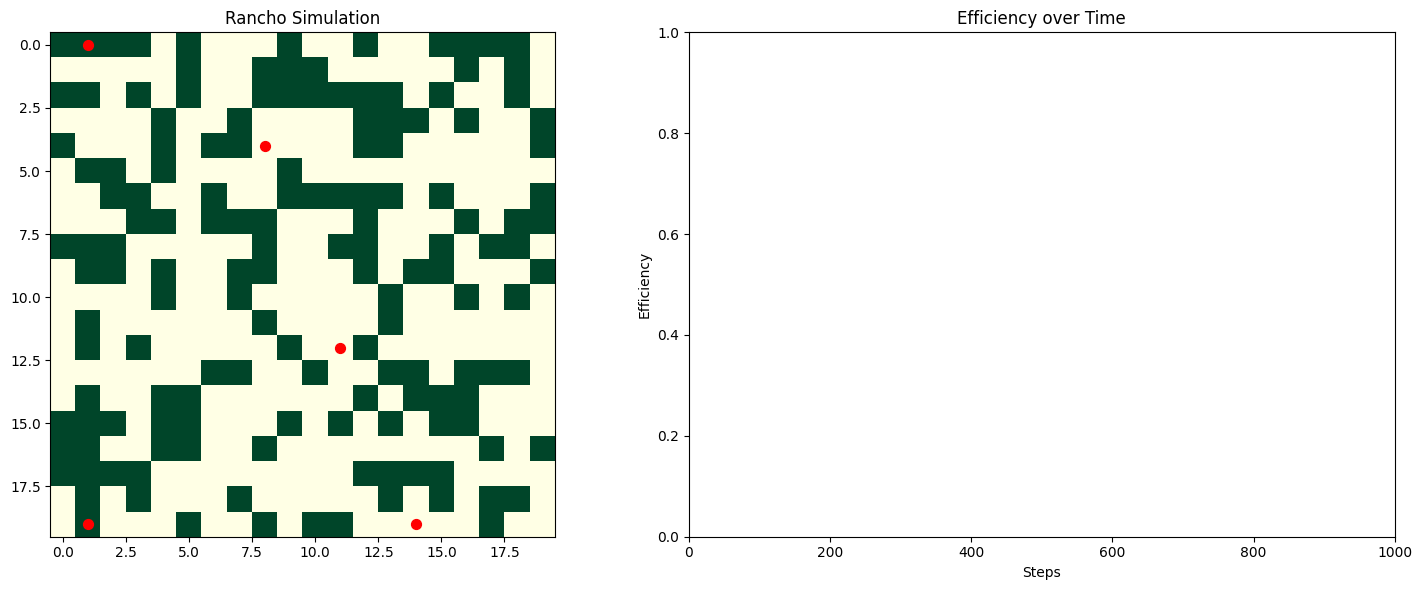

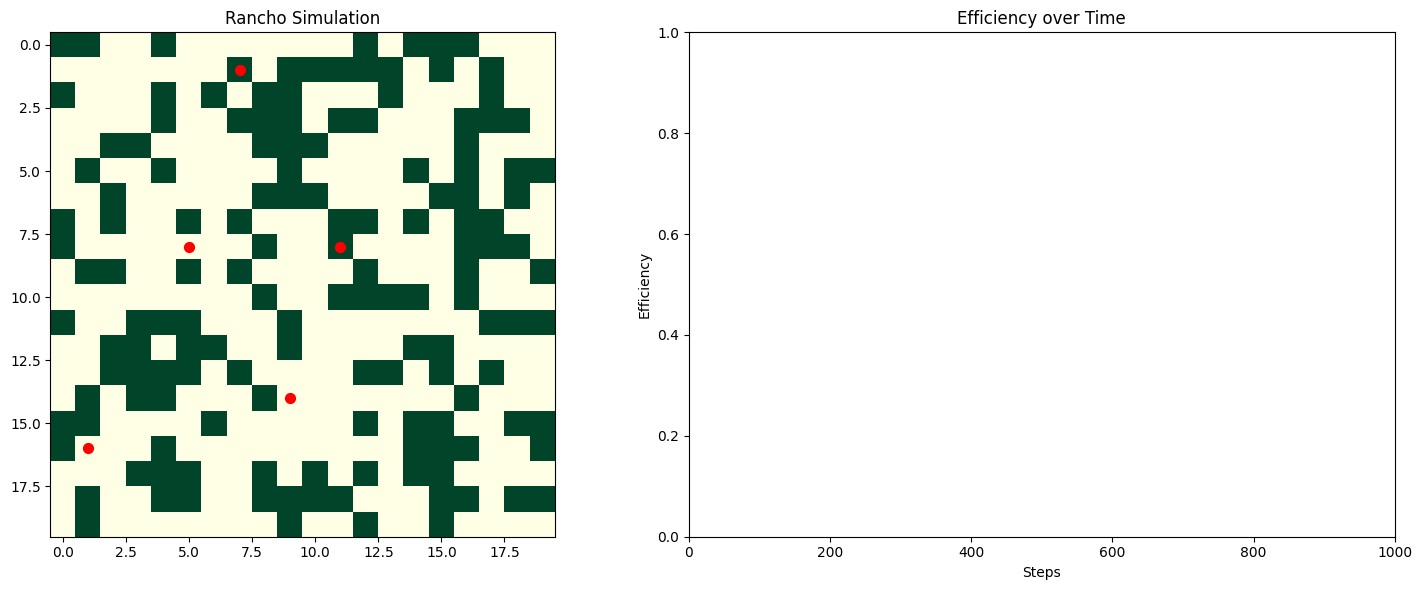

In [10]:
def animate_simulation(strategy):
    model = Rancho(strategy=strategy)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    sheep_plot = ax1.imshow(model.sheep_layer, cmap='YlGn', interpolation='nearest', vmin=0, vmax=1)
    pastor_scatter = ax1.scatter([], [], c='red', s=50)
    ax1.set_title('Rancho Simulation')
    
    efficiency_line, = ax2.plot([], [], 'b-')
    ax2.set_xlim(0, 1000)
    ax2.set_ylim(0, 1)
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Efficiency')
    ax2.set_title('Efficiency over Time')

    def update(frame):
        finished = model.step()
        
        sheep_plot.set_array(model.sheep_layer)
        
        pastor_positions = [agent.pos for agent in model.schedule.agents]
        pastor_scatter.set_offsets(pastor_positions)
        
        efficiency_line.set_data(range(len(model.efficiency_history)), model.efficiency_history)
        
        if finished or frame == 999:
            ani.event_source.stop()
        
        return sheep_plot, pastor_scatter, efficiency_line

    ani = FuncAnimation(fig, update, frames=1000, interval=50, blit=True)
    plt.tight_layout()
    plt.show()

# Ejecutar la simulación con diferentes estrategias
animate_simulation("random")
animate_simulation("coordinated")